In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv

sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
import data_vis_utils as dvu
import shapely
from tqdm import tqdm, tqdm_notebook
import os
import pandas as pd

Font size is set to 10


In [64]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')

tmp = dvu.print_table_results_per_species(ds=ds, filepath_train_val_split='../../content/split_indices_2024-03-04-1831.pth',
                                          save_table=True)

Font size is set to 10
Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Number of samples in train set: 947
Number of samples in val set: 196
Number of samples in test set: 186


In [59]:
tmp

,species,P(presence) train [\%],P(presence) val [\%],P(presence) test [\%]
0,Melanargia galathea,10.61,12.36,14.10
1,Pieris napi,37.77,36.88,37.70
2,Aphantopus hyperantus,23.88,24.12,25.74
3,Aglais io,31.16,30.56,30.29
4,Polyommatus icarus,35.88,39.20,41.89
...,...,...,...,...
57,Melitaea cinxia,0.06,0.00,0.00
58,Carterocephalus palaemon,0.12,0.00,0.00
59,Nymphalis polychloros,0.00,0.04,0.01
60,Nymphalis antiopa,0.01,0.00,0.00


In [42]:
tmp = dvu.print_table_mlplayers_pretrained(save_table=True)
tmp = dvu.print_table_mlplayers_pretrained_lr(save_table=True)

Font size is set to 10
Loaded stats from PECL-ImEn_2024-03-04-2244_vnum-324_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2302_vnum-325_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2321_vnum-326_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2339_vnum-327_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2357_vnum-328_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0016_vnum-329_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0035_vnum-330_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0053_vnum-331_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0112_vnum-332_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024

In [39]:
tmp[1]

,MLP,Pretrained,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,nan,Mean rates,67.3,58.7,1.39
1,1.0,ImageNet,68.9 $\pm$ 0.8,60.9 $\pm$ 1.0,1.33 $\pm$ 0.05
2,1.0,SeCo,69.1 $\pm$ 0.5,61.8 $\pm$ 0.9,1.34 $\pm$ 0.04
3,2.0,ImageNet,\textbf{69.7 $\pm$ 0.5},61.5 $\pm$ 0.7,1.24 $\pm$ 0.03
4,2.0,SeCo,69.5 $\pm$ 0.4,\textbf{62.4 $\pm$ 0.8},1.22 $\pm$ 0.04
5,3.0,ImageNet,69.0 $\pm$ 0.5,61.8 $\pm$ 0.7,1.24 $\pm$ 0.03
6,3.0,SeCo,69.6 $\pm$ 0.2,62.4 $\pm$ 1.0,\textbf{1.21 $\pm$ 0.04}


In [25]:
tmp = dvu.print_table_cr_32(split_use='test', save_table=True)

Loaded stats from PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1049_vnum-396_st

In [26]:
tmp[0]

pecl_knn pecl_knn_hard_labels training_method alpha_ratio_loss  \
                                                                   
0        2                 True            pred              0.0   
1        1                False   pred_and_pecl              0.1   
2        2                False   pred_and_pecl              0.1   
3        5                False   pred_and_pecl              0.1   
4        1                False   pred_and_pecl              0.3   
5        2                False   pred_and_pecl              0.3   
6        5                False   pred_and_pecl              0.3   

  batch_size_used        name_train_loss    Top-10               Top-5  \
                                              mean       sem      mean   
0              64               pred-bce  0.695699  0.001728  0.624373   
1              32  pred-bce_pecl-softmax  0.698029  0.006810  0.624014   
2              32  pred-bce_pecl-softmax  0.695878  0.005468  0.624373   
3              32  pred-bce_pecl-softmax  0.700179  0.002350  0.622939   
4              32  pred-bce_pecl-softmax  0.697133  0.006409  0.625090   
5              32  pred-bce_pecl-softmax  0.698566  0.007586  0.622581   
6              32  pred-bce_pecl-softmax  0.695878  0.005760  0.621147   

                  MSE            
        sem      mean       sem  
0  0.009901  0.012108  0.000370  
1  0.008429  0.012069  0.000341  
2  0.005868  0.012307  0.000191  
3  0.006218  0.012078  0.000305  
4  0.006462  0.012084  0.000436  
5  0.006541  0.012254  0.000382  
6  0.006341  0.012320  0.000302

In [27]:
tmp[1]

,$k$,$\alpha$,Batch,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,2,0.0,64,69.6 $\pm$ 0.2,62.4 $\pm$ 1.0,1.21 $\pm$ 0.04
1,1,0.1,32,69.8 $\pm$ 0.7,62.4 $\pm$ 0.8,\textbf{1.21 $\pm$ 0.03}
2,2,0.1,32,69.6 $\pm$ 0.5,62.4 $\pm$ 0.6,1.23 $\pm$ 0.02
3,5,0.1,32,\textbf{70.0 $\pm$ 0.2},62.3 $\pm$ 0.6,1.21 $\pm$ 0.03
4,1,0.3,32,69.7 $\pm$ 0.6,\textbf{62.5 $\pm$ 0.6},1.21 $\pm$ 0.04
5,2,0.3,32,69.9 $\pm$ 0.8,62.3 $\pm$ 0.7,1.23 $\pm$ 0.04
6,5,0.3,32,69.6 $\pm$ 0.6,62.1 $\pm$ 0.6,1.23 $\pm$ 0.03


In [28]:
list_vnums = list(np.arange(386, 405))
list_vnums.remove(389)  # broken run
list_vnums = list_vnums + [335, 338, 341]  # alpha=0 runs
tmp_df, tmp_details = dvu.create_df_list_timestamps(list_ts=dvu.get_list_timestamps_from_vnums(
    list_vnums=list_vnums), split_use='test')

Loaded stats from PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1049_vnum-396_st

In [35]:
tmp_df[tmp_df.columns[13:-3]]

,pecl_knn,pecl_knn_hard_labels,training_method,alpha_ratio_loss,normalise_embedding,use_mps,use_lr_scheduler,seed_used,batch_size_used,p_dropout,verbose,time_created,name_train_loss,n_epochs_converged,test_top_20_acc,test_top_10_acc,test_top_5_acc,test_top_1_acc
0,1,False,pred_and_pecl,0.1,l2,True,False,42,32,0,1,2024-03-05-2322:14,pred-bce_pecl-softmax,51,0.853226,0.704839,0.640860,0.424731
1,1,False,pred_and_pecl,0.3,l2,True,False,42,32,0,1,2024-03-05-2337:42,pred-bce_pecl-softmax,51,0.850806,0.704839,0.637634,0.446237
2,1,False,pred_and_pecl,0.1,l2,True,False,17,32,0,1,2024-03-05-2353:10,pred-bce_pecl-softmax,51,0.855376,0.684409,0.616129,0.333333
3,1,False,pred_and_pecl,0.3,l2,True,False,17,32,0,1,2024-03-06-0859:16,pred-bce_pecl-softmax,51,0.855914,0.684409,0.621505,0.349462
4,1,False,pred_and_pecl,0.1,l2,True,False,86,32,0,1,2024-03-06-0915:17,pred-bce_pecl-softmax,51,0.848118,0.704839,0.615054,0.435484
5,1,False,pred_and_pecl,0.3,l2,True,False,86,32,0,1,2024-03-06-0930:54,pred-bce_pecl-softmax,51,0.844892,0.702150,0.616129,0.413978
6,2,False,pred_and_pecl,0.1,l2,True,False,42,32,0,1,2024-03-06-0946:28,pred-bce_pecl-softmax,51,0.851344,0.701613,0.632258,0.365591
7,2,False,pred_and_pecl,0.3,l2,True,False,42,32,0,1,2024-03-06-1002:21,pred-bce_pecl-softmax,51,0.853226,0.712903,0.633333,0.435484
8,2,False,pred_and_pecl,0.1,l2,True,False,17,32,0,1,2024-03-06-1017:55,pred-bce_pecl-softmax,51,0.850538,0.684946,0.627957,0.360215
9,2,False,pred_and_pecl,0.3,l2,True,False,17,32,0,1,2024-03-06-1033:42,pred-bce_pecl-softmax,51,0.851882,0.687097,0.623656,0.317204


Font size is set to 10
Loaded stats from PECL-ImEn_2024-03-06-1136_vnum-399_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1207_vnum-401_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1328_vnum-403_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0207_vnum-335_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0303_vnum-338_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0358_vnum-341_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean rates top_5: 0.5870967507362366
Loaded stats from PECL-ImEn_2024-03-05-1941_vnum-380_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2000_vnum-381_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2018_vnum-382_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2036_vnum-383_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2055_vnum-384_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2113_vnum-385_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean rates top_5: 0.5870967507362366
Loaded stats from PECL-ImEn_2024-03-06-1136_vnum-399_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1207_vnum-401_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1328_vnum-403_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0207_vnum-335_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0303_vnum-338_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0358_vnum-341_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean rates top_10: 0.6731182336807251
Loaded stats from PECL-ImEn_2024-03-05-1941_vnum-380_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2000_vnum-381_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2018_vnum-382_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2036_vnum-383_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2055_vnum-384_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2113_vnum-385_stats.pkl at /Users/t.vanderplas/models/PECL/stats/


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean rates top_10: 0.6731182336807251


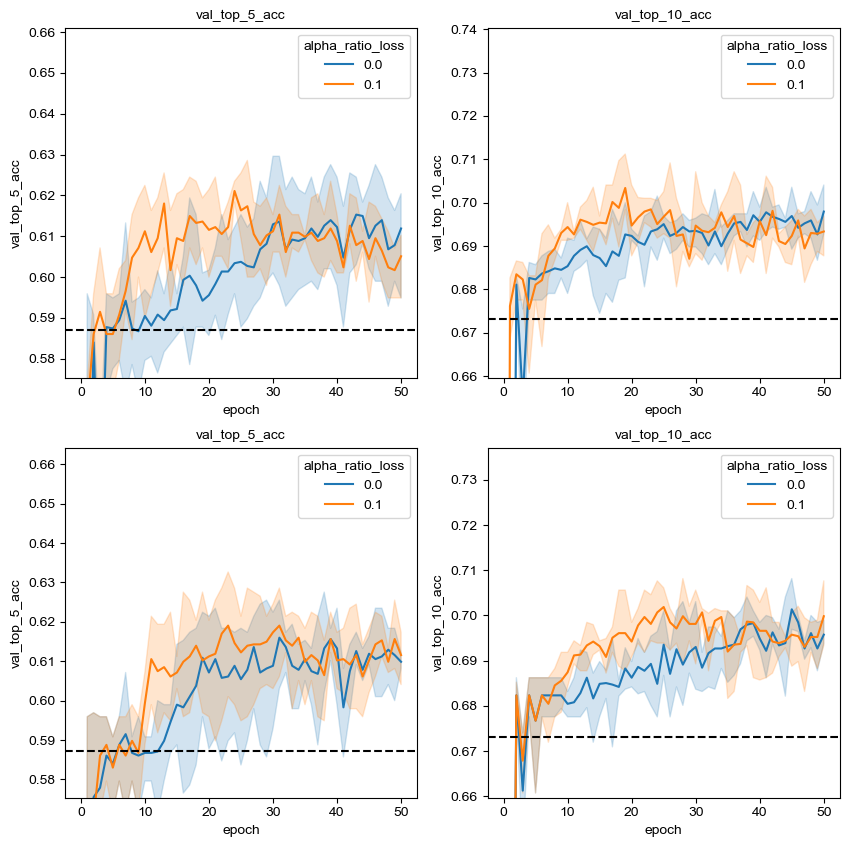

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# list_vnums = list(np.arange(386, 405))
# list_vnums.remove(389)  # broken run
# list_vnums = list_vnums
list_vnums_1 = [399, 401, 403] + [335, 338, 341]  # alpha=0 runs

for i_plot, metric in enumerate(['val_top_5_acc', 'val_top_10_acc']):
    tmp = dvu.plot_val_timeseries(list_ts=dvu.get_list_timestamps_from_vnums(list_vnums=list_vnums_1),
                              metric_show=metric, ax=ax[0, i_plot], hue_hparam='alpha_ratio_loss')
    ax[0, i_plot].set_title(metric)
    tmp = dvu.plot_val_timeseries(list_ts=dvu.get_list_timestamps_from_vnums(np.arange(380, 386)),
                              metric_show=metric, ax=ax[1, i_plot])
    ax[1, i_plot].set_title(metric)

In [31]:
# tmp = dvu.print_table_test(split_use='test', save_table=False, list_vnums=np.arange(405, 411))
tmp = dvu.print_table_model_changes(save_table=True)

Loaded stats from PECL-ImEn_2024-03-06-1546_vnum-405_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1606_vnum-406_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1625_vnum-407_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1645_vnum-408_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1705_vnum-409_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1724_vnum-410_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0207_vnum-335_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0303_vnum-338_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0358_vnum-341_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1136_vnum-399_st

In [30]:
tmp[1]

,Freeze Res,LR,$k$,$\alpha$,Batch,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,NaN,nan,nan,nan,nan,67.3,58.7,1.39
1,False,0.0001,1.0,0.0,64.0,68.2 $\pm$ 0.5,61.7 $\pm$ 0.7,1.29 $\pm$ 0.05
2,False,0.001,1.0,0.0,64.0,68.2 $\pm$ 0.2,61.8 $\pm$ 0.8,1.32 $\pm$ 0.03
3,True,0.001,2.0,0.0,64.0,69.6 $\pm$ 0.2,\textbf{62.4 $\pm$ 1.0},1.21 $\pm$ 0.04
4,True,0.001,5.0,0.1,32.0,\textbf{70.0 $\pm$ 0.2},62.3 $\pm$ 0.6,\textbf{1.21 $\pm$ 0.03}


In [18]:
tmp = dvu.print_table_cr_32(save_table=False)

Font size is set to 10
Loaded stats from PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024

In [24]:
tmp[['timestamp', 'pecl_knn', 'alpha_ratio_loss', 'seed_used']]

,timestamp,pecl_knn,alpha_ratio_loss,seed_used
0,PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl,1,0.1,42
1,PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl,1,0.3,42
2,PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl,1,0.1,17
3,PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl,1,0.3,17
4,PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl,1,0.1,86
5,PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl,1,0.3,86
6,PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl,2,0.1,42
7,PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl,2,0.3,42
8,PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl,2,0.1,17
9,PECL-ImEn_2024-03-06-1049_vnum-396_stats.pkl,2,0.3,17
